In [12]:
import keras
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import os
from urllib.parse import urlparse
from skimage.io import imread
from PIL import Image, ImageEnhance
from PIL import ImageFilter
from skimage.transform import resize
import image_utils as iu
from keras.datasets import mnist
from keras.models import Sequential
# from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM, BatchNormalization
from keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import Input, Model
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import numpy_utils as nu

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr


In [2]:
data_path = 'data'
segmentation_path = os.path.join(data_path, 'segmentation')

# mining_path = os.path.join(segmentation_path, 'mining')
# training data paths
training_path = os.path.join(segmentation_path, 'training')
#train
train_path = os.path.join(training_path, 'train')
train_real_path = os.path.join(train_path, 'real')
train_mask_path = os.path.join(train_path, 'mask')
#val
val_path = os.path.join(training_path, 'val')
val_real_path = os.path.join(val_path, 'real')
val_mask_path = os.path.join(val_path, 'mask')
#test
test_path = os.path.join(training_path, 'test')
test_real_path = os.path.join(test_path, 'real')
test_mask_path = os.path.join(test_path, 'mask')
# Saved models
saved_model_path = os.path.join(segmentation_path, 'saved-models')
# Checkpoint path
checkpoint_path = os.path.join(segmentation_path, 'train_ckpt')
checkpoint_file_path = os.path.join(checkpoint_path, "multi_class_segmentation.ckpt")
# Predictions path.
prediction_path = os.path.join(segmentation_path, 'predictions')
# Predicted image path.


In [3]:
# import os
# import rasterio
# import numpy as np
from tensorflow.keras.utils import Sequence
import ntpath


def preprocess_data(data):
    # Add your preprocessing function here
    return data

class DataGenerator(Sequence):
    def __init__(self, image_dir, batch_size=32, shuffle=True, real_data_preprocessing_function=None, mask_data_preprocessing_function=None):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.size = (160, 160)
        self.real_data_preprocessing_function = real_data_preprocessing_function
        self.mask_data_preprocessing_function = mask_data_preprocessing_function
        self.image_list, self.mask_list = self.__load_filenames()
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_list) // self.batch_size

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        image_list_temp = [self.image_list[k] for k in indexes]
        mask_list_temp = [self.mask_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(image_list_temp, mask_list_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __load_filenames(self):
        # image_list = []
        mask_list = []
        image_list = iu.get_all_files(
            os.path.join(self.image_dir, 'real'), '*.npz', True)
        for real_image_path in image_list:
            mask_path = os.path.join(self.image_dir, 'mask', ntpath.basename(
                real_image_path).replace('.npz', '.png'))
            if not os.path.isfile(mask_path):
               raise Exception("Cannot find mask for " + real_image_path)
            mask_list.append(mask_path)
        print(
            f"Found {len(image_list)} image pair.")
        return image_list, mask_list

    def __data_generation(self, image_list_temp, mask_list_temp):
        width, height = self.size
        X = np.empty((self.batch_size, height, width, 6))
        y = np.empty((self.batch_size, height, width))
        for i, (image_name, mask_name) in enumerate(zip(image_list_temp, mask_list_temp)):
            np_gt = nu.load_numpy_file(image_name)
            mask_image = iu.read_image(mask_name, 'L')
            if np_gt.shape != (height, width):
                np_gt = nu.resize_np_image(np_gt, self.size)
            if mask_image.size != self.size:
                mask_image =mask_image.resize(self.size)
            np_mask_image = np.asarray(mask_image, dtype='uint8')
            if self.real_data_preprocessing_function != None:
                np_gt = self.real_data_preprocessing_function(np_gt)
            if self.mask_data_preprocessing_function != None:
                np_mask_image = self.mask_data_preprocessing_function(np_mask_image)
            X[i, ] = np_gt
            y[i, ] = np_mask_image       
        return X, y


In [4]:
#Converts the image into a numpy array and normalizes the pixel values.
def real_image_preprocessing_func(np_gt):
    return np_gt / 13029

#Converts the mask into a numpy array and normalizes the pixel values.
#Values are also rounded to create a sharp image.
def mask_preprocessing_func(np_mask):
    return np_mask / 255


In [5]:
# load and iterate training dataset
image_width = 160
image_height = 160
batch_size = 8
image_size = (image_width, image_height)
train_datagen = DataGenerator(train_path, batch_size, False,
                              real_data_preprocessing_function=real_image_preprocessing_func)
val_datagen = DataGenerator(val_path, batch_size, False,
                            real_data_preprocessing_function=real_image_preprocessing_func)
test_datagen = DataGenerator(test_path, batch_size, False,
                             real_data_preprocessing_function=real_image_preprocessing_func)


Found 72734 image pair.
Found 12834 image pair.
Found 0 image pair.


In [ ]:
# A folder for saving checkpoint is created for
iu.create_dir_if_not_exists(checkpoint_path)
# Create a callback that saves the model's weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    verbose=0,
    save_weights_only=True,
    save_freq='epoch')


## Modelling
Image segmentation is achieved with the U-net architecture.<br>
To improve the training performance transfer learning techniques are used.<br>
The encoder block of the U-Net model is made up of layers of a pre-trained<br>
VGG16 model with weights updated using *imagenet*.

In [6]:
from tensorflow.keras.initializers import RandomNormal

# Define conv block.
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Define Decoder block
def define_decoder(inputs, skip_layer, num_filters):
    init = RandomNormal(stddev=0.02)
    x = Conv2DTranspose(num_filters, (2, 2), strides=(
        2, 2), padding='same', kernel_initializer=init)(inputs)
    g = Concatenate()([x, skip_layer])
    g = conv_block(g, num_filters)
    return g

In [22]:
# Creates a VGG16 Unet model
def vgg16_unet(input_shape , n_classes):
    inputs = Input(shape=input_shape)
    vgg16 = VGG16(include_top=False, weights='imagenet',
                  input_shape=input_shape, input_tensor=inputs)  # We will extract encoder layers based on their output shape from vgg16 model
    # vgg16(inputs)
    s1 = vgg16.get_layer('block1_conv2').output
    s2 = vgg16.get_layer('block2_conv2').output
    s3 = vgg16.get_layer('block3_conv3').output
    # bottleneck/bridege layer from vgg16
    s4 = vgg16.get_layer('block4_conv3').output
    b1 = vgg16.get_layer('block5_conv3').output  # 32
    # Decoder Block
    d1 = define_decoder(b1, s4, 512)
    d2 = define_decoder(d1, s3, 256)
    d3 = define_decoder(d2, s2, 128)
    d4 = define_decoder(d3, s1, 64)  # output layer
    outputs = Conv2D(n_classes, 1, padding='same')(d4)
    model = Model(inputs, outputs)
    return model

In [ ]:
#Build vgg unet model 1
input_size = (image_height, image_width, 4)
lr = 1e-4
model = vgg16_unet(input_size, 24)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()


In [6]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection


def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
        n_filters,
        (3, 3),    # Kernel size
        strides=(2, 2),
        padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                  3,     # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    return conv


In [7]:
input_size = (image_height, image_width, 6)
n_filters = 64
n_classes = 24

# Input size represent the size of 1 image (the size used for pre-processing)
inputs = Input(input_size)

# Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
# Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, max_pooling=True)
cblock2 = EncoderMiniBlock(
    cblock1[0], n_filters*2, dropout_prob=0, max_pooling=True)
cblock3 = EncoderMiniBlock(
    cblock2[0], n_filters*4, dropout_prob=0, max_pooling=True)
cblock4 = EncoderMiniBlock(
    cblock3[0], n_filters*8, dropout_prob=0.3, max_pooling=True)
cblock5 = EncoderMiniBlock(
    cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

# Decoder includes multiple mini blocks with decreasing number of filters
# Observe the skip connections from the encoder are given as input to the decoder
# Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

# Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
# Followed by a 1x1 Conv layer to get the image to the desired size.
# Observe the number of channels will be equal to number of output classes
conv9 = Conv2D(n_filters,
               3,
               activation='relu',
               padding='same',
               kernel_initializer='he_normal')(ublock9)

conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=conv10)
# model1.compile(loss=dice_loss, optimizer='adam', metrics=[
#               dice_coef, iou])
model.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()


2023-01-02 21:27:49.723155: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 6) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 64) 3520        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 160, 160, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [89]:
history = model.fit(
    train_datagen,
    steps_per_epoch=len(train_datagen.image_list) / batch_size,
    epochs=10,
    validation_data=val_datagen,
    validation_steps=len(val_datagen.image_list) / batch_size,
    verbose=1)


Epoch 1/10
9091/9091 [==============================] - 55733s 6s/step - loss: 1.2786 - accuracy: 0.5528 - val_loss: 1.2351 - val_accuracy: 0.5749


In [ ]:
model.fit(train_datagen, len(train_datagen.image_list) / batch_size,
          validation_data=validation_generator, validation_steps=len(validation_generator), epochs=10)


In [94]:
#Model is saved as h5 format after training.
from datetime import datetime
iu.create_dir_if_not_exists(saved_model_path)
model.save(os.path.join(saved_model_path, 'multi_class_unet_model_' +
                        str(datetime.now()).replace(':', '-') + '.h5'))

In [ ]:
model.evaluate(val_datagen)

In [ ]:
y_pred = model.predict(test_gen)

In [18]:
# The color code or legend for each class is defined for visualization
new_color_encoding = {0: [255, 0, 0],  # Degraded Gallery Forest
                      1: [60, 154, 206],  # Wetland
                      2: [0, 255, 0],  # Plantation
                      3: [98, 124, 61],  # Mangrove
                      4: [217, 212, 12],  # Agric
                      5: [0, 1, 128],  # Waterbody
                      6: [255, 223, 167],  # Sandy Area
                      7: [180, 96, 0],  # Rocky Land
                      8: [142, 125, 115],  # Bare Soil
                      9: [251, 72, 196],  # Settlement
                      10: [179, 227, 214],  # Irrigated Agric
                      11: [255, 128, 64],  # Gallery
                      12: [41, 49, 28],  # Shrub and Tee Savanna
                      13: [231, 177, 106],  # Wooded Savanna
                      14: [65, 100, 34],  # Forest
                      15: [50, 50, 50],  # Salt Pan
                      16: [119, 85, 60],  # Degraded
                      17: [128, 64, 255],  # Bowe
                      # Agriculture in Shallow and Recession
                      18: [90, 64, 128],
                      19: [255, 64, 64],  # Woodland
                      20: [0, 255, 255],  # Dam
                      21: [128, 0, 64],  # Herbaecous Savanna
                      22: [255, 255, 255],  # Shrub Land
                      23: [0, 0, 0]}  # No data

In [37]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

# Predicts the mask of an image.
def predict_mask(unet, np_img, input_size):
    # split image
    image_width, image_height = input_size
    np_img = nu.resize_np_image(np_img, (image_height, image_width))
    np_img = np_img / 13029
    pred = unet.predict(np.array([np_img]))
    return np.asarray(create_mask(pred))
    # print(pred[0].max())
    mask = np.round(pred[0])
    # print(mask)
    mask = mask * 255
    mask = Image.fromarray(mask.reshape(
        image_height, image_width)).convert("L")
    return mask


In [38]:
def display_np_geoTiff(np_geoTiff):
    np_rgb_image = np_geoTiff[:, :, 0:3][:, :, ::-1]
    np_n_im = (np_rgb_image / np_rgb_image.max()) * 255
    im = Image.fromarray(np.array(np_n_im, dtype=np.uint8))
    return im

In [39]:
def display_legend(np_image, color_encoding):
    flat_gh_im = np_image.reshape(-1, 1)
    #
    new_gh_im = []
    for x in range(flat_gh_im.shape[0]):
        new_gh_im.append(color_encoding.get(flat_gh_im[x][0], [0, 0, 0]))
    #
    new_gh_im = np.array(new_gh_im).reshape(
        np_image.shape[0], np_image.shape[1], 3)
    enc_im = Image.fromarray(np.array(new_gh_im, dtype=np.uint8))
    return enc_im

In [119]:
np_gt = nu.load_numpy_file(
    'data/segmentation/training/val/real/fc66aec4-d08f-4d7c-ad40-754a4ffc90f9.npz')
mask_image = iu.read_image(
    'data/segmentation/training/val/mask/fc66aec4-d08f-4d7c-ad40-754a4ffc90f9.png')

np_gt = nu.load_numpy_file(
    'data/segmentation/divided/real/0cf927dc-1371-4206-9c1c-480a02fdccdd.npz')
mask_image = iu.read_image(
    'data/segmentation/divided/mask/0cf927dc-1371-4206-9c1c-480a02fdccdd.png')


In [121]:
mask = predict_mask(model, np_gt, (160, 160))

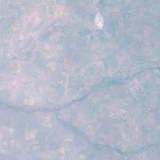

In [118]:
display_np_geoTiff(np_gt)

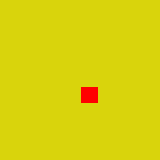

In [120]:
np_mask = np.asarray(mask_image)
display_legend(np_mask, new_color_encoding)

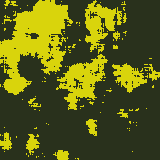

In [122]:
display_legend(mask, new_color_encoding)